In [1]:
import pandas as pd

data = pd.read_csv('training_data.csv')
data.patient = data.patient
data

,patient,image,channel
0,1,LA_ED,0
1,1,LA_ES,0
2,1,SA_ED,0
3,1,SA_ED,1
4,1,SA_ED,2
...,...,...,...
3869,160,SA_ES,2
3870,160,SA_ES,3
3871,160,SA_ES,4
3872,160,SA_ES,5


In [2]:
limit = 120
data_train = data[data.patient <= limit]
data_val = data[data.patient > limit]

data_train.patient = data_train.patient.astype(str).str.zfill(3)
data_val.patient = data_val.patient.astype(str).str.zfill(3)

C:\Users\sensio\miniconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [3]:
data_train

,patient,image,channel
0,001,LA_ED,0
1,001,LA_ES,0
2,001,SA_ED,0
3,001,SA_ED,1
4,001,SA_ED,2
...,...,...,...
2899,120,SA_ES,7
2900,120,SA_ES,8
2901,120,SA_ES,9
2902,120,SA_ES,10


In [4]:
data_val

,patient,image,channel
2904,121,LA_ED,0
2905,121,LA_ES,0
2906,121,SA_ED,0
2907,121,SA_ED,1
2908,121,SA_ED,2
...,...,...,...
3869,160,SA_ES,2
3870,160,SA_ES,3
3871,160,SA_ES,4
3872,160,SA_ES,5


In [5]:
import torch 
import nibabel as nib

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, path = 'data/MnM-2/training', trans=None):
        self.path = path
        self.data = data
        self.trans = trans
        self.num_classes = 4
        self.max_val = {
            'LA_ED': 4104.,
            'LA_ES': 7875.,
            'SA_ED': 11510.,
            'SA_ES': 9182.
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ix):
        patient = self.data.iloc[ix].patient
        image = self.data.iloc[ix].image
        channel = self.data.iloc[ix].channel

        img = nib.load(f'{self.path}/{patient}/{patient}_{image}.nii.gz').get_fdata()[...,channel] / self.max_val[image]
        mask = nib.load(f'{self.path}/{patient}/{patient}_{image}_gt.nii.gz').get_fdata()[...,channel].astype(np.int)
        if self.trans:
            t = self.trans(image=img, mask=mask)
            img = t['image']
            mask = t['mask'] 
        img_t = torch.from_numpy(img).float().unsqueeze(0)
        # mask encoding
        mask_oh = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()
        return img_t, mask_oh

In [163]:
import albumentations as A

trans = A.Compose([
    #A.Resize(224, 224),
    A.PadIfNeeded(224, 224, border_mode=0, value=0),
    A.RandomResizedCrop(224, 224),
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.Transpose(),
    A.GridDistortion(p=0.2),
    #A.ElasticTransform(),
    A.GaussianBlur()
])

ds = {
    'train': Dataset(data_train, trans=trans),
    'val': Dataset(data_val, trans=trans)
}

img, mask = ds['train'][0]
img.shape, mask.shape

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(torch.Size([1, 224, 224]), torch.Size([4, 224, 224]))

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


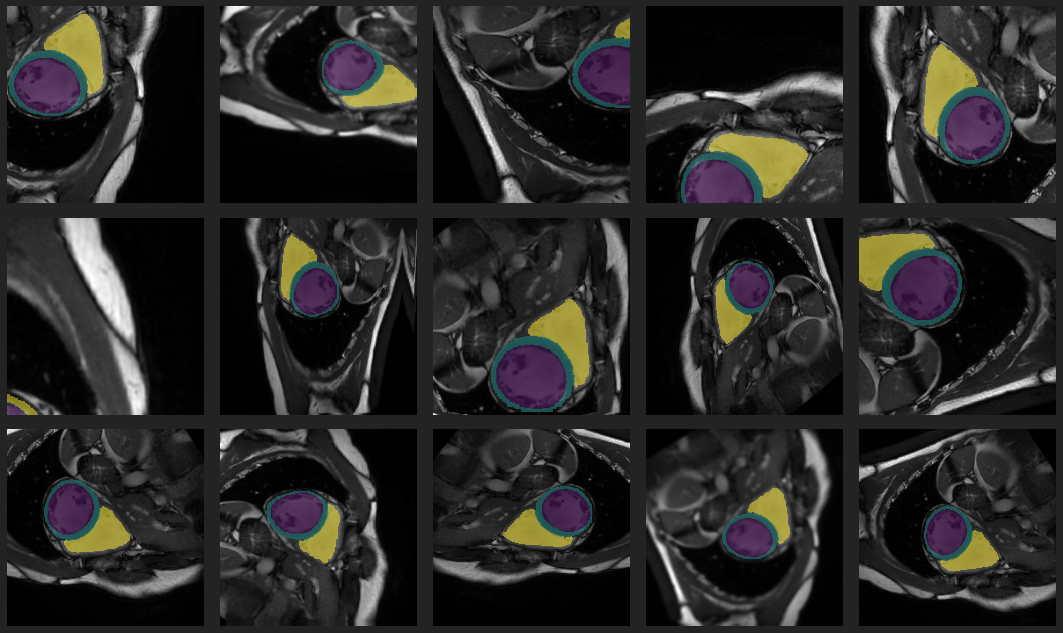

In [167]:
import matplotlib.pyplot as plt
import random 

ixx = random.randint(0, len(ds['train']))

r, c = 3, 5
fig = plt.figure(figsize=(3*c, 3*r))
for i in range(r):
    for j in range(c):
        img, mask = ds['train'][ixx]
        ix = c*i + j
        ax = plt.subplot(r, c, ix + 1)
        ax.imshow(img.squeeze(0), cmap="gray")
        mask = torch.argmax(mask, axis=0).float().numpy()
        mask[mask == 0] = np.nan
        ax.imshow(mask, alpha=0.5)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [50]:
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=25, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=25, shuffle=False, pin_memory=True),
}

imgs, masks = next(iter(dl['train']))
imgs.shape, masks.shape

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(torch.Size([25, 1, 224, 224]), torch.Size([25, 4, 224, 224]))

In [90]:
def plot_history(hist):
    graph_ax1.clear()
    graph_ax2.clear()
    graph_ax1.plot(hist['loss'], label='loss')
    graph_ax1.plot(hist['val_loss'], label='val_loss')
    graph_ax2.plot(hist['iou'], label='iou')
    graph_ax2.plot(hist['val_iou'], label='val_iou')
    graph_ax1.legend(loc='upper right')
    graph_ax2.legend(loc='upper right')
    graph_ax1.grid(True)
    graph_ax2.grid(True)
    graph_ax1.set_yscale("log")
    graph_out.update(graph_fig)

In [91]:
def IoU(pr, gt, th=0.5, eps=1e-7):
    pr = torch.sigmoid(pr) > th
    gt = gt > th
    intersection = torch.sum(gt * pr, axis=(-2,-1))
    union = torch.sum(gt, axis=(-2,-1)) + torch.sum(pr, axis=(-2,-1)) - intersection + eps
    ious = (intersection + eps) / union
    return torch.mean(ious).item()

In [92]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

output = model(imgs)
output.shape, masks.shape

(torch.Size([25, 4, 224, 224]), torch.Size([25, 4, 224, 224]))

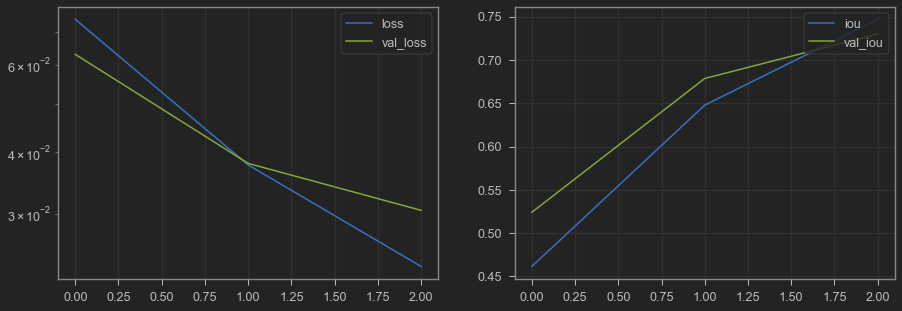

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


KeyboardInterrupt: 

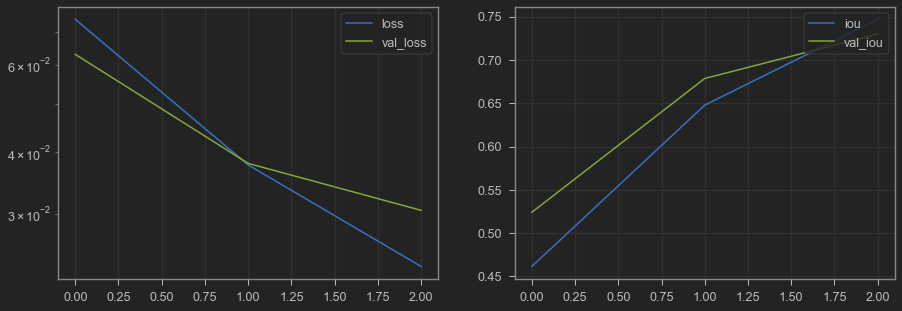

In [112]:
from fastprogress import master_bar, progress_bar

batch_size=64
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=batch_size, shuffle=False, pin_memory=True),
}
epochs = 10
lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.cuda()
mb = master_bar(range(1, epochs+1))
graph_fig, (graph_ax1, graph_ax2) = plt.subplots(1, 2, figsize=(15, 5))
graph_out = display(graph_fig, display_id=True)
hist = {'loss': [], 'val_loss': [], 'iou': [], 'val_iou': []}
for e in mb:
    # training
    model.train()
    l, i = [], []
    for batch in progress_bar(dl['train'], parent=mb):
        optimizer.zero_grad()
        imgs, masks = batch
        imgs, masks = imgs.cuda(), masks.cuda()
        preds = model(imgs)
        loss = F.binary_cross_entropy_with_logits(preds, masks)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        i.append(IoU(preds, masks))
        mb.child.comment = f'training ... loss {np.mean(l):.4f} iou {np.mean(i):.4f}'
    hist['loss'].append(np.mean(l))
    hist['iou'].append(np.mean(i))
    # evaluation
    model.eval()
    vl, vi = [], []
    with torch.no_grad():
        for batch in progress_bar(dl['val'], parent=mb):
            imgs, masks = batch
            imgs, masks = imgs.cuda(), masks.cuda()
            preds = model(imgs)
            loss = F.binary_cross_entropy_with_logits(preds, masks)
            vl.append(loss.item())
            vi.append(IoU(preds, masks))
            mb.child.comment = f'evaluating... loss {np.mean(l):.4f} iou {np.mean(i):.4f} val_loss {np.mean(vl):.4f} val_iou {np.mean(vi):.4f}'
    mb.main_bar.comment = f'Epoch {e}/{epochs} loss {np.mean(l):.4f} val_loss {np.mean(vl):.4f} iou {np.mean(i):.4f} val_iou {np.mean(vi):.4f}'
    hist['val_loss'].append(np.mean(vl))
    hist['val_iou'].append(np.mean(vi))
    plot_history(hist)

In [113]:
imgs, masks = next(iter(dl['val']))
preds = model.predict(imgs.cuda()).cpu()
    
preds.shape

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


torch.Size([64, 4, 224, 224])

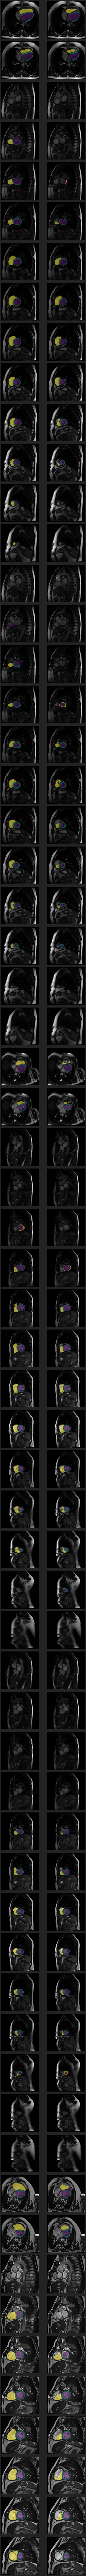

In [114]:
fig = plt.subplots(figsize=(8, 3*len(imgs)))
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):
    ax = plt.subplot(len(imgs), 2, 2*i + 1)
    ax.imshow(img[0], cmap="gray")
    mask = torch.argmax(mask, axis=0).float().numpy()
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 2, 2*i + 2)
    ax.imshow(img[0], cmap="gray")
    pred = torch.argmax(pred, axis=0).float().numpy()
    pred[pred == 0] = np.nan
    ax.imshow(pred, alpha=0.5)
    ax.axis('off')
plt.tight_layout()    
plt.show()

In [115]:
torch.save(model.state_dict(), 'checkpoint.pt')

In [110]:
model_loaded = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

model_loaded.load_state_dict(torch.load('checkpoint.pt'))
preds = model_loaded.predict(imgs).cpu()
    
preds.shape

torch.Size([64, 4, 224, 224])